In [142]:
import numpy as np
import matplotlib.pyplot as plt
from zernike import RZern
import h5py
import os
from astropy.io import fits

basedir = os.environ['HOME']

In [195]:
cart = RZern(6)
L, K = 663, 663
ddx = np.linspace(-1.0, 1.0, K)
ddy = np.linspace(-1.0, 1.0, L)
xv, yv = np.meshgrid(ddx, ddy)
cart.make_cart_grid(xv, yv)

In [198]:
num_polynomials = 28
zernike_matrix = np.empty((L*K, num_polynomials))

In [199]:
c = np.zeros(cart.nk)
for i in range(num_polynomials):
    c *= 0.0
    c[i] = 1.0
    Phi = cart.eval_grid(c, matrix=True)
    Phi[Phi != Phi] = 0.
    flattened_zernike = Phi.flatten()
    zernike_matrix[:, i] = flattened_zernike

In [201]:
def generate_zernike_basis(norder, imgsize, npolys=28):
    cart = RZern(6)
    L, K = imgsize, imgsize
    ddx = np.linspace(-1.0, 1.0, K)
    ddy = np.linspace(-1.0, 1.0, L)
    xv, yv = np.meshgrid(ddx, ddy)
    cart.make_cart_grid(xv, yv)
    zernike_matrix = np.empty((L*K, npolys))
    c = np.zeros(cart.nk)
    for i in range(npolys):
        c *= 0.0
        c[i] = 1.0
        Phi = cart.eval_grid(c, matrix=True) #mean is zero
        Phi[Phi != Phi] = 0.
        norm_factor = np.sqrt(np.sum((Phi)**2) / Phi.shape[0]**2)
        Phi /= norm_factor
        # Phi *= 0.6328
        # print(np.sqrt(np.sum(Phi**2) / imgsize))
        flattened_zernike = Phi.flatten()
        zernike_matrix[:, i] = flattened_zernike
    return zernike_matrix

In [128]:
def compute_command(surfcoeffs,zernbasis,dmsize):
    basis_matrix = zernbasis.copy()
    for i in range(num_polynomials):
        basis_matrix[:,i] = basis_matrix[:,i] * surfcoeffs[i]

    # Sum all the scaled images to create a single image
    summed_image = np.sum(basis_matrix, axis=1)

    # Reshape the summed image to the original image size
    original_image_size = (dmsize,dmsize)
    summed_image = summed_image.reshape(original_image_size)
    return summed_image

In [60]:
#Read in the hdf5
file_path = f'{basedir}/projects/psf_reconstruction/frame_00000.h5'  # Replace with the path to your HDF5 file
hdf5_file = h5py.File(file_path, 'r')  # 'r' for read-only mode

group = hdf5_file['measurement0']  # Replace 'group_name' with the actual group name
dataset = group['genraw']  # Replace 'dataset_name' with the actual dataset name

#Convert the data to a numpy array and flatten it
data = dataset['data']
attributes = dataset.attrs
data = data[:]
data[data > 2.0] = 0.

(439569,)


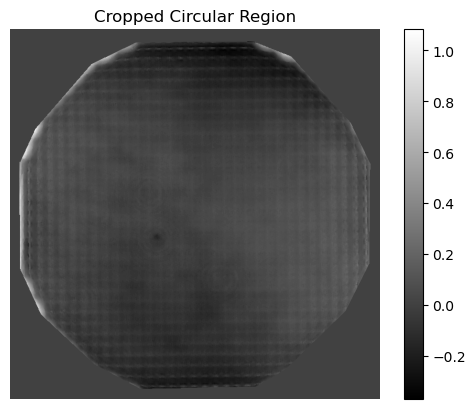

In [129]:
#Crop the numpy array given the xy-coords for the center and radius.

image_size = 1218

# Define the center (x, y) and radius of the circular region
center_x = 621
center_y = 642
radius = 331

# Calculate the coordinates of the upper-left and lower-right corners of the square bounding box
upper_left_x = center_x - radius
upper_left_y = center_y - radius
lower_right_x = center_x + radius
lower_right_y = center_y + radius

# Crop the circular region from the original image
circular_region = data[upper_left_y:lower_right_y + 1, upper_left_x:lower_right_x + 1]

# Verify the shape of the circular region (should be square with side length equal to the diameter)
# diameter = 2 * radius
# assert circular_region.shape == (diameter, diameter)

surface_data_flat = circular_region.flatten()

print(surface_data_flat.shape)

# Optionally, you can visualize the cropped circular region
plt.imshow(circular_region, cmap='gray')
plt.colorbar()
plt.title('Cropped Circular Region')
plt.axis('off')
plt.show()

In [203]:
surface_basis = generate_zernike_basis(norder=15,imgsize=663,npolys=28)
coeffs = np.dot(surface_data_flat, surface_basis) / 663**2

print(coeffs)

[-5.05150070e-12 -1.05211805e-11 -1.01699614e-11  3.80189730e-11
  2.13636575e-02  5.92040820e-02  3.72286906e-03 -1.74973522e-02
 -9.41563737e-04  4.63660904e-03  1.30121089e-02 -1.60193884e-02
 -7.84890022e-03 -5.92735532e-03 -2.15680061e-03 -4.06476684e-03
 -1.09501872e-02 -5.50956547e-03  1.05033633e-03 -2.50518043e-04
 -3.54712616e-04  9.92169829e-03 -3.38107213e-03 -1.08341624e-02
 -4.59221865e-04  4.01677808e-03 -1.77951475e-04 -3.63801002e-03]


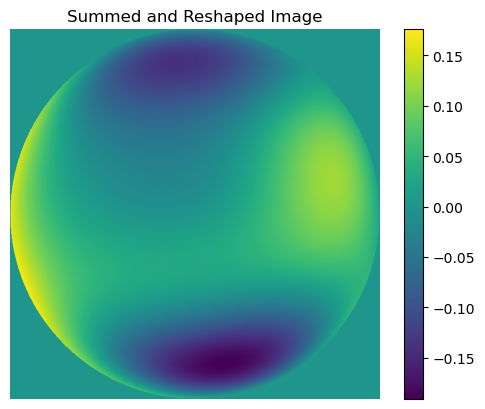

In [204]:
scale_factors = coeffs

scaled_zernike_matrix = zernike_matrix.copy()

for i in range(num_polynomials):
    scaled_zernike_matrix[:,i] = scaled_zernike_matrix[:,i] * scale_factors[i]

# Sum all the scaled images to create a single image
summed_image = np.sum(scaled_zernike_matrix[:,1:], axis=1)

# Reshape the summed image to the original image size
original_image_size = (L, K)
summed_image = summed_image.reshape(original_image_size)

# Optionally, you can visualize the summed and reshaped image
plt.imshow(summed_image, cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Summed and Reshaped Image')
plt.axis('off')
plt.show()

In [206]:
#Make the command basis

command_basis = generate_zernike_basis(norder=15,imgsize=34,npolys=28)



(34, 34)


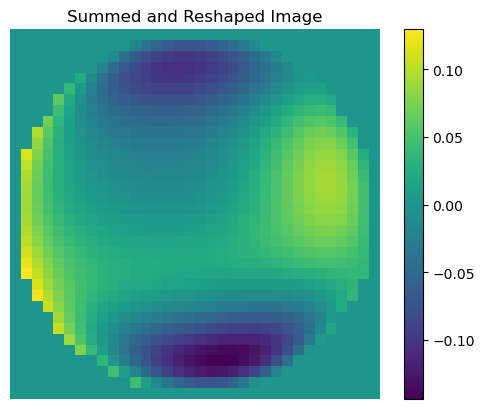

In [207]:


summed_image = compute_command(scale_factors,command_basis,dmsize=34) * 0.6328

fits.writeto(f'{basedir}/projects/psf_reconstruction/test_command.fits',
             summed_image, overwrite=True)

print(summed_image.shape)

# Optionally, you can visualize the summed and reshaped image
plt.imshow(summed_image, cmap='viridis', origin='lower')
plt.colorbar()
plt.title('Summed and Reshaped Image')
plt.axis('off')
plt.show()

(1024, 1024)


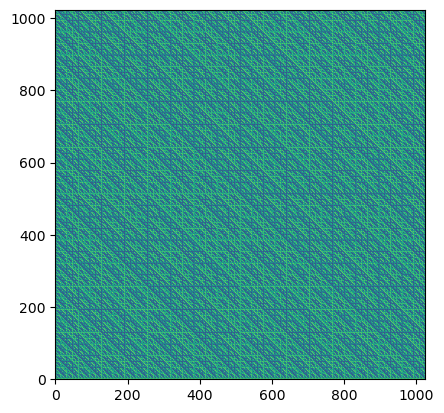

In [192]:
from scipy.linalg import hadamard

def get_hadamard_modes(Nact):
    np2 = 2**int(np.ceil(np.log2(Nact)))
    #print(f'Generating a {np2}x{np2} Hadamard matrix.')
    hmat = hadamard(np2)
    return hmat#[:Nact,:Nact]

modes = get_hadamard_modes(Nact=952)

print(modes.shape)

plt.imshow(modes,origin='lower')
plt.show()